In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-default-new/Loan_default.csv
/kaggle/input/dish-network-hackathon/Sample_Submission.csv
/kaggle/input/dish-network-hackathon/Data_Dictionary.csv
/kaggle/input/dish-network-hackathon/Train_Dataset.csv
/kaggle/input/dish-network-hackathon/Test_Dataset.csv


In [46]:
# 1. General Utilities & Data Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Preprocessing & Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample, compute_class_weight

# 3. Individual Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# 4. Ensemble Methods
from sklearn.ensemble import VotingClassifier, StackingClassifier

# 5. Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

#6. Add Ons ~ Misc
import random
# =========================
import warnings
from sklearn.feature_selection import mutual_info_classif

# =========================
# 2. Suppress Non-Critical Warnings
# =========================
warnings.filterwarnings(
    "ignore",
    category=UserWarning
)

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning
)

warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

In [47]:
df = pd.read_csv('/kaggle/input/loan-default-new/Loan_default.csv', low_memory=False)
df.head(10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,High School,Unemployed,Single,Yes,No,Business,Yes,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0
7,0HGZQKJ36W,56,126802,155511,531,67,4,8.15,60,0.43,PhD,Full-time,Married,No,No,Home,Yes,0
8,1R0N3LGNRJ,36,42053,92357,827,83,1,23.94,48,0.20,Bachelor's,Self-employed,Divorced,Yes,No,Education,No,1
9,CM9L1GTT2P,40,132784,228510,480,114,4,9.09,48,0.33,High School,Self-employed,Married,Yes,No,Other,Yes,0


In [48]:
df.groupby(['Default'])['LoanID'].nunique() #Imbalanced DataSet

Default
0    225694
1     29653
Name: LoanID, dtype: int64

In [49]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

In [50]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [51]:
# Split minority
minority = df[df.Default == 1]
majority = df[df.Default == 0]

# Undersample majority for training
majority_train = majority.sample(n=len(minority), random_state=42)

# Balanced training pool
train_pool = pd.concat([minority, majority_train])


In [52]:
# ----------------------------
# 1. Feature Definitions
# ----------------------------
TARGET = "Default"
DROP_COLS = ["LoanID"]

num_continuous = [
    "Age", "Income", "LoanAmount", "CreditScore",
    "MonthsEmployed", "NumCreditLines",
    "InterestRate", "LoanTerm", "DTIRatio"
]

cat_binary = [
    "HasMortgage", "HasDependents", "HasCoSigner"
]

cat_nominal = [
    "Education", "EmploymentType", "MaritalStatus", "LoanPurpose"
]

# Scalers / Encoders
numeric_scaler = StandardScaler()
binary_encoder = OrdinalEncoder(
    categories=[["No", "Yes"]] * len(cat_binary)
)
nominal_encoder = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_continuous),
        ("bin", OrdinalEncoder(categories=[["No", "Yes"]] * len(cat_binary)), cat_binary),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_nominal)
    ]
)

# ----------------------------
# 3. Train-Test Split
# ----------------------------
X = train_pool.drop(columns=DROP_COLS + [TARGET])
y = train_pool[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ----------------------------
# 4. Model Pipelines
# ----------------------------
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pipelines = {
    "LogisticRegression": Pipeline([
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            solver="liblinear",
            random_state=42
        ))
    ]),

    "RandomForest": Pipeline([
        ("preprocessing", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "XGBoost": Pipeline([
        ("preprocessing", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
            random_state=42,
            n_jobs=-1,
            tree_method='hist',        # GPU acceleration
            device='cuda',
            enable_categorical=True,  
            early_stopping_rounds=50
           
        ))
    ])
}



# ----------------------------
# 5. Hyperparameter Grids
# ----------------------------
param_grids = {
    "LogisticRegression": {
        "model__C": [0.1],
        "model__penalty": ["l1"]
    },

    "RandomForest": {
        "model__max_depth": [10],
        "model__min_samples_leaf": [50],
        "model__max_features": ["sqrt"]
    },

    "XGBoost": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.7, 0.9],
        "model__colsample_bytree": [0.7, 0.9]
    }
}


# ----------------------------
# 6. Training + Evaluation
# ----------------------------
# Initialize dictionaries to store results
results = {}
best_models = {}

for name in pipelines:
    print(f"\n===== Training {name} =====")

    # 1. Split out validation set
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
    )

    # 2. IMPORTANT: Pre-fit the preprocessor and transform X_val
    # This converts text to numbers so early_stopping can read it
    preprocessor.fit(X_train_sub)
    X_val_transformed = preprocessor.transform(X_val)

    # 3. Initialize GridSearchCV
    grid = GridSearchCV(
        estimator=pipelines[name],
        param_grid=param_grids[name],
        scoring="f1",
        cv=3,
        n_jobs=-1
    )

    # 4. Set fit_params using the TRANSFORMED validation set
    fit_params = {}
    
    if name == "XGBoost":
        fit_params = {
            "model__eval_set": [(X_val_transformed, y_val)],
            "model__verbose": False  # XGBoost still uses this
        }
        
    elif name == "LightGBM":
        from lightgbm import log_evaluation, early_stopping
        fit_params = {
            "model__eval_set": [(X_val_transformed, y_val)],
            "model__callbacks": [early_stopping(stopping_rounds=50)] 
            # LightGBM uses callbacks instead of verbose/early_stopping_rounds in fit()
        }
        
    elif name == "CatBoost":
        fit_params = {
            "model__eval_set": [(X_val_transformed, y_val)],
            "model__verbose": 0  # CatBoost uses verbose=0
        }

    # 5. Fit the grid
    grid.fit(X_train_sub, y_train_sub, **fit_params)

    # 6. Save best model and evaluate
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

    print(f"Finished training {name}, best params: {grid.best_params_}")

# ----------------------------
# 7. Results Summary
# ----------------------------
summary = pd.DataFrame({
    model: {
        "Accuracy": results[model]["Accuracy"],
        "Precision": results[model]["Precision"],
        "Recall": results[model]["Recall"],
        "F1": results[model]["F1"],
        "ROC_AUC": results[model]["ROC_AUC"]
    }
    for model in results
}).T

print("\n===== MODEL PERFORMANCE SUMMARY =====")
print(summary)




===== Training LogisticRegression =====
Finished training LogisticRegression, best params: {'model__C': 0.1, 'model__penalty': 'l1'}

===== Training RandomForest =====
Finished training RandomForest, best params: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 50}

===== Training XGBoost =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:53:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:53:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Finished training XGBoost, best params: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 0.7}

===== MODEL PERFORMANCE SUMMARY =====
                    Accuracy  Precision    Recall        F1   ROC_AUC
LogisticRegression  0.677710   0.673184  0.690777  0.681867  0.746147
RandomForest        0.680408   0.676743  0.690777  0.683688  0.746766
XGBoost             0.683612   0.680477  0.692295  0.686335  0.751713


Training Voting Classifier (Soft)...
Training Stacking Classifier (Meta-Learner: LogReg)...

XGBoost (Best Single) Report
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      5931
           1       0.68      0.69      0.69      5931

    accuracy                           0.68     11862
   macro avg       0.68      0.68      0.68     11862
weighted avg       0.68      0.68      0.68     11862


Voting Ensemble Report
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      5931
           1       0.68      0.70      0.69      5931

    accuracy                           0.68     11862
   macro avg       0.68      0.68      0.68     11862
weighted avg       0.68      0.68      0.68     11862


Stacking Ensemble Report
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      5931
           1       0.68      0.69      0.69      5931

    accura

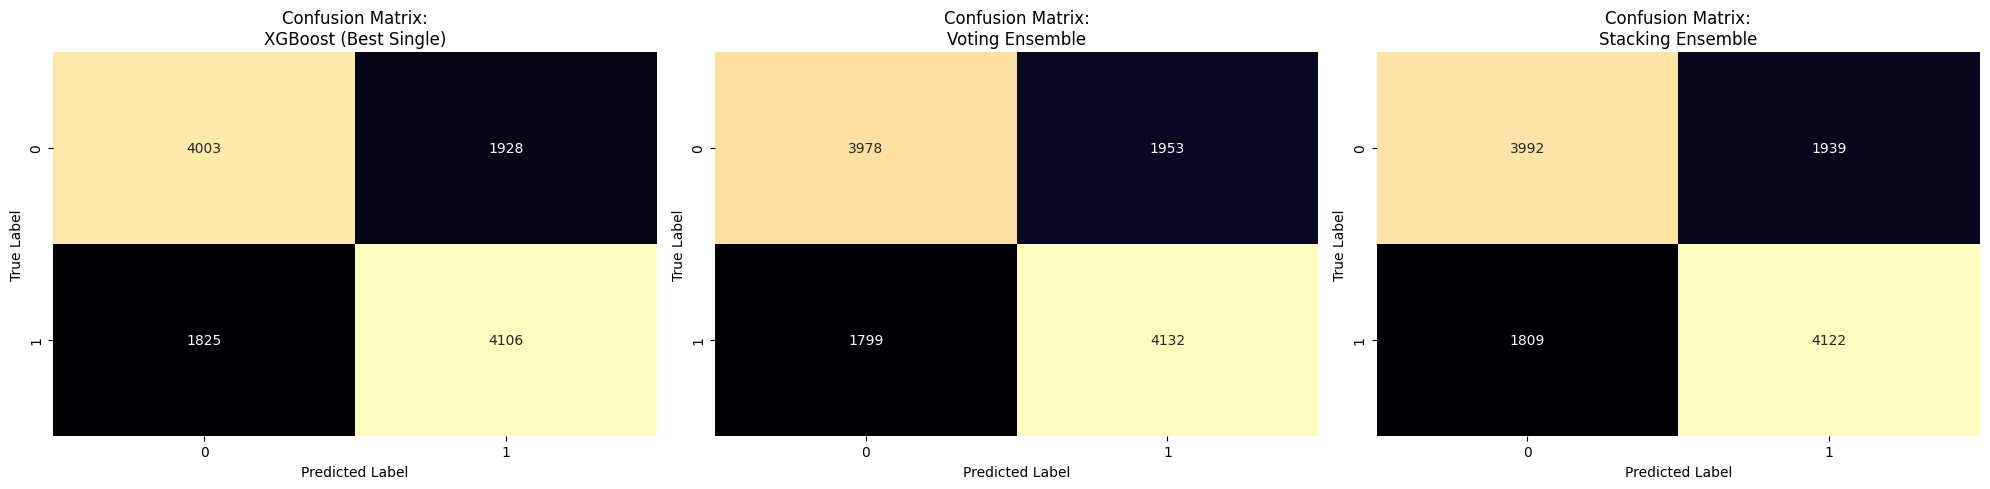


===== FINAL MODEL COMPARISON =====
                       Accuracy  F1-Score   ROC_AUC
Voting Ensemble        0.683696  0.687750  0.751414
Stacking Ensemble      0.684033  0.687458  0.751969
XGBoost (Best Single)  0.683612  0.686335  0.751713


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ----------------------------
# 1. Prepare "Ensemble-Ready" Models
# ----------------------------
# We clone the best XGBoost and disable early_stopping_rounds 
# because ensembles don't support eval_set during the .fit() call.
xgb_ensemble_ready = clone(best_models['XGBoost'])
xgb_ensemble_ready.set_params(model__early_stopping_rounds=None)

# ----------------------------
# 2. Define Ensembles
# ----------------------------
voting_model = VotingClassifier(
    estimators=[
        ('lr', best_models['LogisticRegression']),
        ('rf', best_models['RandomForest']),
        ('xgb', xgb_ensemble_ready)
    ],
    voting='soft'
)

stacking_model = StackingClassifier(
    estimators=[
        ('lr', best_models['LogisticRegression']),
        ('rf', best_models['RandomForest']),
        ('xgb', xgb_ensemble_ready)
    ],
    final_estimator=LogisticRegression(),
    cv=3,       # Reduced CV to 3 for faster training on Kaggle
    n_jobs=1    # Keep sequential to avoid GPU/Memory collisions
)

# ----------------------------
# 3. Train Ensembles
# ----------------------------
print("Training Voting Classifier (Soft)...")
voting_model.fit(X_train, y_train)

print("Training Stacking Classifier (Meta-Learner: LogReg)...")
stacking_model.fit(X_train, y_train)

# ----------------------------
# 4. Evaluation & Visualization
# ----------------------------
final_comparison = {}
models_to_compare = {
    "XGBoost (Best Single)": best_models['XGBoost'],
    "Voting Ensemble": voting_model,
    "Stacking Ensemble": stacking_model
}

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, (name, model) in enumerate(models_to_compare.items()):
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store Metrics
    final_comparison[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }
    
    # Print Text Report
    print(f"\n{'='*30}\n{name} Report\n{'='*30}")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix:\n{name}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()

# ----------------------------
# 5. Final Summary Table
# ----------------------------
summary_df = pd.DataFrame(final_comparison).T
print("\n===== FINAL MODEL COMPARISON =====")
print(summary_df.sort_values(by="F1-Score", ascending=False))